In [163]:
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

In [164]:
from skimage.color import rgb2hsv
from skimage.morphology import closing, opening, disk, remove_small_holes, remove_small_objects, binary_dilation
from skimage.transform import rotate, resize
from sklearn.metrics.pairwise import euclidean_distances
from skimage.measure import regionprops, label
from skimage.measure import find_contours
from skimage.util import img_as_bool
from skimage.feature import local_binary_pattern


import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Callable
from datetime import datetime
from collections import defaultdict
from sklearn.cluster import DBSCAN

Function definitions

In [165]:
def linear_interpolation(contours: np.ndarray, n_samples: int = 80):
    N = len(contours)
    contours_inter = np.zeros((N, n_samples, 2))
    
    for i in range(N):
        x = contours[i][:, 0]
        y = contours[i][:, 1]

        t = np.zeros(len(x))
        t[1:] = np.cumsum(np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2))

        t_prime = np.linspace(0, t[-1], n_samples)

        contours_inter[i, :, 0] = np.interp(t_prime, t, x)
        contours_inter[i, :, 1] = np.interp(t_prime, t, y)
    
    return contours_inter

In [166]:
def sliding_window_compare(image_rgb, reference_histograms, window_size=64, stride=16, method='hist'):
    H, W, _ = image_rgb.shape
    heatmap = np.zeros((H // stride, W // stride))

    for y in range(0, H - window_size + 1, stride):
        for x in range(0, W - window_size + 1, stride):
            patch = image_rgb[y:y+window_size, x:x+window_size]

            # Compute feature of patch
            if method == 'hist':
                patch_hist = cv2.calcHist([patch], [0, 1, 2], None, [16, 16, 16], [0, 256]*3)
                patch_hist = cv2.normalize(patch_hist, patch_hist).flatten().astype(np.float32)

                # Compare to all reference histograms
                min_dist = min([
                    cv2.compareHist(patch_hist, ref_hist, cv2.HISTCMP_BHATTACHARYYA)
                    for ref_hist in reference_histograms
                ])
                similarity = 1.0 - min_dist  # invert for similarity
                
            heatmap[y // stride, x // stride] = similarity

    return heatmap

In [167]:
def sliding_window_classify_and_count(image_rgb, reference_histograms, reference_names, 
                                      window_size=64, stride=16, method='hist',
                                      similarity_threshold=0.7, cluster=False):
    H, W, _ = image_rgb.shape
    heatmap = np.zeros((H // stride, W // stride))
    count_dict = defaultdict(int)

    positions_by_type = defaultdict(list)  

    for y in range(0, H - window_size + 1, stride):
        for x in range(0, W - window_size + 1, stride):
            patch = image_rgb[y:y+window_size, x:x+window_size]

            if method == 'hist':
                patch_hist = cv2.calcHist([patch], [0, 1, 2], None, [16, 16, 16], [0, 256]*3)
                patch_hist = cv2.normalize(patch_hist, patch_hist).flatten().astype(np.float32)

                similarities = [1.0 - cv2.compareHist(patch_hist, ref_hist, cv2.HISTCMP_BHATTACHARYYA)
                                for ref_hist in reference_histograms]
                
                best_idx = int(np.argmax(similarities))
                best_sim = similarities[best_idx]

                if best_sim > similarity_threshold:
                    count_dict[reference_names[best_idx]] += 1
                    positions_by_type[reference_names[best_idx]].append((x, y))

                heatmap[y // stride, x // stride] = best_sim

    if cluster:
        clustered_counts = {}
        for choco_type, positions in positions_by_type.items():
            if not positions:
                clustered_counts[choco_type] = 0
                continue
            X = np.array(positions)
            clustering = DBSCAN(eps=window_size, min_samples=1).fit(X)
            clustered_counts[choco_type] = len(set(clustering.labels_))
        return heatmap, clustered_counts

    return heatmap, dict(count_dict)


In [222]:
def optimize_similarity_threshold(train_image_rgb, reference_histograms, ref_image_names,
                                  heatmap, blobs, window_size=80, stride=10,
                                  threshold_range=(0.1, 0.9), threshold_step=0.05):

    num_blobs = len(blobs)
    
    best_threshold = None
    best_diff = float('inf')
    best_counts = None

    thresholds = np.arange(threshold_range[0], threshold_range[1] + threshold_step, threshold_step)
    
    for threshold in thresholds:
        _, counts = sliding_window_classify_and_count(
            train_image_rgb, reference_histograms, ref_image_names,
            window_size=window_size, stride=stride, similarity_threshold=threshold,
            cluster=True
        )
        total_detected = sum(counts.values())
        diff = abs(num_blobs - total_detected)

        if diff < best_diff:
            best_diff = diff
            best_threshold = threshold
            best_counts = counts
    
    return best_threshold, best_counts, best_diff

In [234]:
def extract_patches_from_blobs(image_rgb, blobs, stride, window_size):

    H, W, _ = image_rgb.shape
    patches = []

    for (y_hm, x_hm, r) in blobs:
        x_img = int(x_hm * stride)
        y_img = int(y_hm * stride)

        x1 = max(0, x_img - window_size // 2)
        y1 = max(0, y_img - window_size // 2)
        x2 = min(W, x1 + window_size)
        y2 = min(H, y1 + window_size)

        if x2 - x1 < window_size or y2 - y1 < window_size:
            continue 

        patch = image_rgb[y1:y2, x1:x2]
        patches.append(patch)

    return patches

Load reference images and plot them with contours

/tmp/ipykernel_2494/12493397.py:30: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  cleaned = remove_small_objects(blurred, min_size=100)
/tmp/ipykernel_2494/12493397.py:31: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  cleaned = remove_small_holes(cleaned, area_threshold=1000)


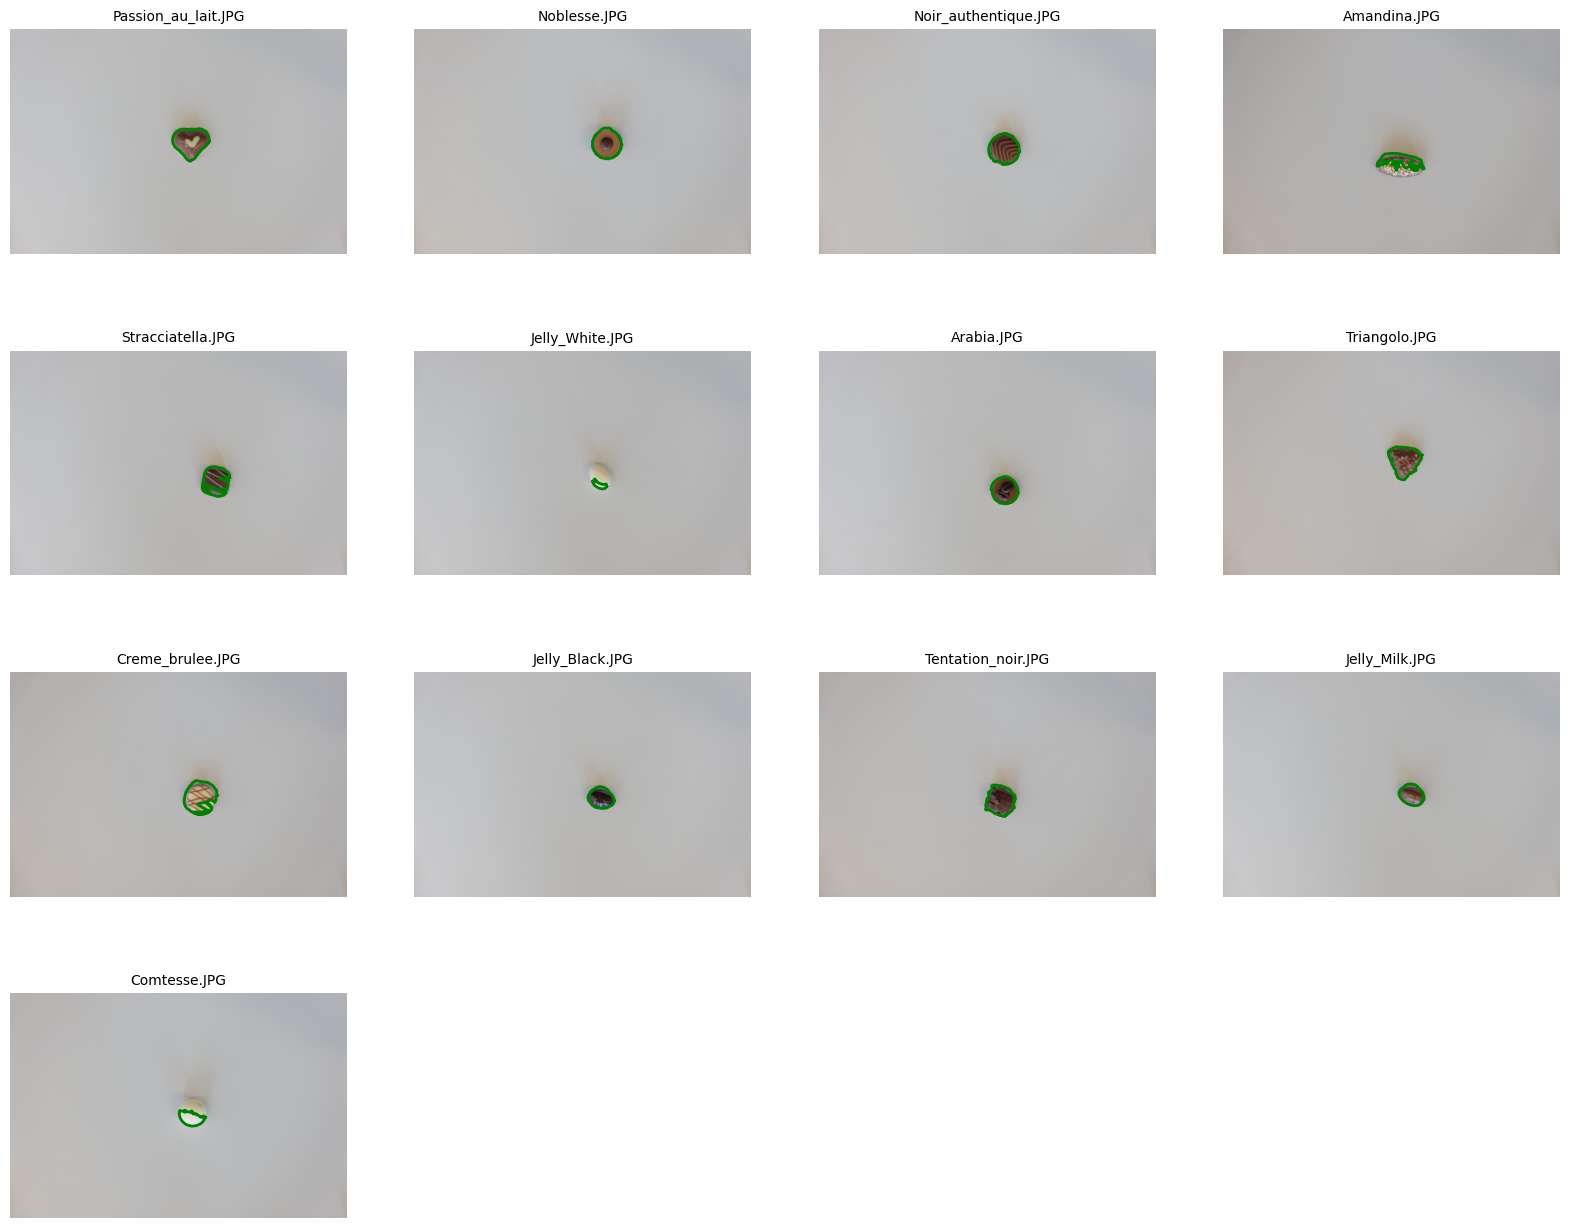

In [168]:
ref_dir = 'chocolate-recognition-classic/dataset_project_iapr2025/references/'
ref_image_names = os.listdir(ref_dir)
ref_images = [cv2.imread(os.path.join(ref_dir, img)) for img in ref_image_names]
ref_images = [cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4)) for img in ref_images]
ref_images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in ref_images]
ref_images_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in ref_images]

reference_histograms = [] # used for sliding window
contours_all = [] 

cols = 4
rows = int(np.ceil(len(ref_image_names) / cols))
plt.figure(figsize=(20, 4 * rows))

for i, gray in enumerate(ref_images_gray):

    # Thresholding
    mean = np.mean(gray)
    std = np.std(gray)
    k1 = 4.5
    k2 = 4.3
    lower = int(max(0, mean - k1 * std))
    upper = int(min(255, mean + k2 * std))

    thresh = np.where((gray < lower) | (gray > upper), 255, 0).astype(np.uint8)

    # Morphological cleaning
    binary = img_as_bool(thresh)
    blurred = cv2.GaussianBlur(binary.astype(np.uint8), (7, 7), 0)
    cleaned = remove_small_objects(blurred, min_size=100)
    cleaned = remove_small_holes(cleaned, area_threshold=1000)
    processed = (cleaned * 255).astype(np.uint8)

    # Find contours
    contour = find_contours(thresh.T)[0]
    interpolated = linear_interpolation([contour], n_samples=80)[0]

    # Calculate histogram inside the contour
    img_copy = ref_images_rgb[i].copy()
    mask = np.zeros(img_copy.shape[:2], dtype=np.uint8)

    if interpolated.shape[0] > 0:
        interpolated_int = np.round(interpolated).astype(np.int32)
        cv2.fillPoly(mask, [interpolated_int], 255)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))  
        mask = cv2.erode(mask, kernel, iterations=1) # make contour smaller to make sure we don't include the background by using morphological erosion

        hist = cv2.calcHist([img_copy], [0, 1, 2], mask, [16, 16, 16], [0, 256]*3)
        
    hist = cv2.normalize(hist, hist).flatten()
    reference_histograms.append(hist)

    plt.subplot(rows, cols, i + 1)

    plt.imshow(img_copy, cmap='gray')
    plt.plot(interpolated[:, 0], interpolated[:, 1], 'g-', linewidth=2)

    plt.title(ref_image_names[i], fontsize=10)
    plt.axis('off')

Load training data

In [228]:
train_dir = 'chocolate-recognition-classic/dataset_project_iapr2025/train/'
train_image_names = os.listdir(train_dir)
random_idx = 1# np.random.randint(0, len(train_image_names))
train_image = cv2.imread(os.path.join(train_dir, train_image_names[random_idx]))
train_image = cv2.resize(train_image, (train_image.shape[1] // 4, train_image.shape[0] // 4))
train_image_rgb = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)

Apply sliding window to the training data

Image size: (1000, 1500, 3)


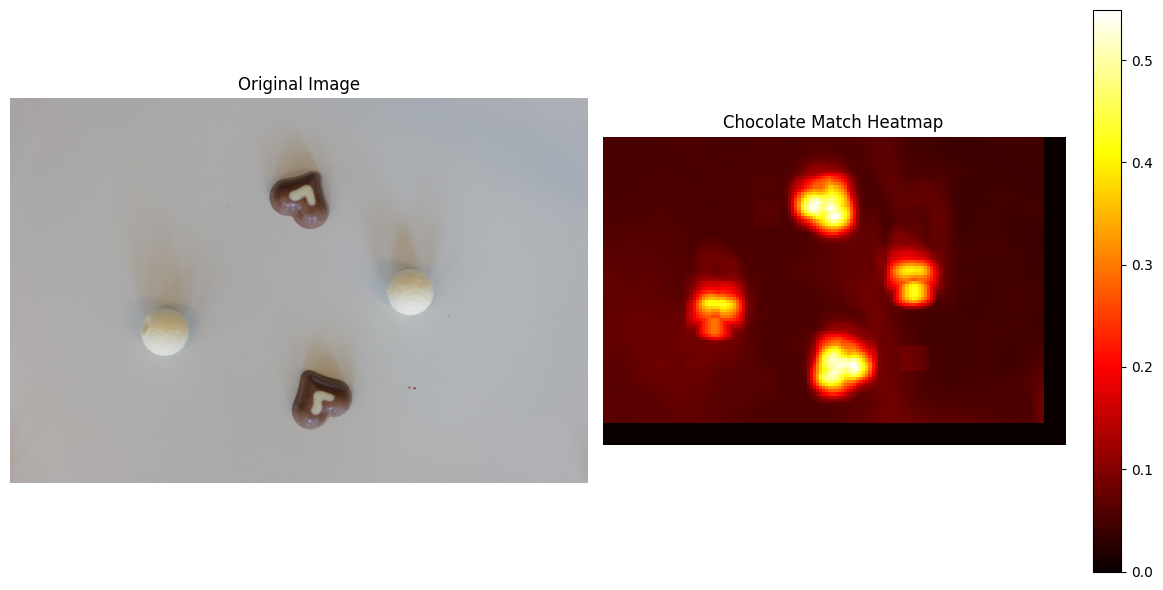

In [229]:
window_size = 80
stride = 10

heatmap = sliding_window_compare(train_image_rgb, reference_histograms, window_size=window_size, stride=stride)

plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(train_image_rgb)
plt.title("Original Image")
plt.axis('off')

# Heatmap
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.title("Chocolate Match Heatmap")
plt.colorbar()
plt.axis('off')

plt.tight_layout()

print("Image size:", train_image_rgb.shape)

Detect number of hotspots

Text(0.5, 1.0, 'Laplacian of Gaussian Blob Detection')

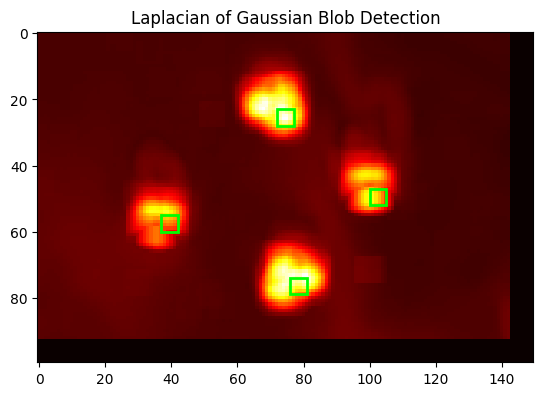

In [240]:
from skimage.feature import blob_log

blobs = blob_log(heatmap, max_sigma=5, threshold=0.1)

plt.imshow(heatmap, cmap='hot')
for y, x, r in blobs:
    c = plt.Rectangle((x, y), r, r, color='lime', linewidth=2, fill=False)
    plt.gca().add_patch(c)
plt.title("Laplacian of Gaussian Blob Detection")

Use number of hotspots to tune the manual threshold such that the number of detected chocolates is closest to number of hotspots

In [ ]:
best_threshold, best_counts, best_diff = optimize_similarity_threshold(
    train_image_rgb, reference_histograms, ref_image_names,
    heatmap, blobs, window_size=80, stride=10,
    threshold_range=(0.02, 0.98), threshold_step=0.02
)

print(f"Optimized threshold: {best_threshold}")
print(f"Chocolate counts at this threshold: {best_counts}")
print(f"Minimal difference to blobs: {best_diff}")

Optimized threshold: 0.5
Chocolate counts at this threshold: {'Noir_authentique.JPG': 2, 'Jelly_Milk.JPG': 2, 'Passion_au_lait.JPG': 2, 'Stracciatella.JPG': 1}
Minimal difference to blobs: 3


Extract patches around the detected hotspots

Extracted 4 patches.


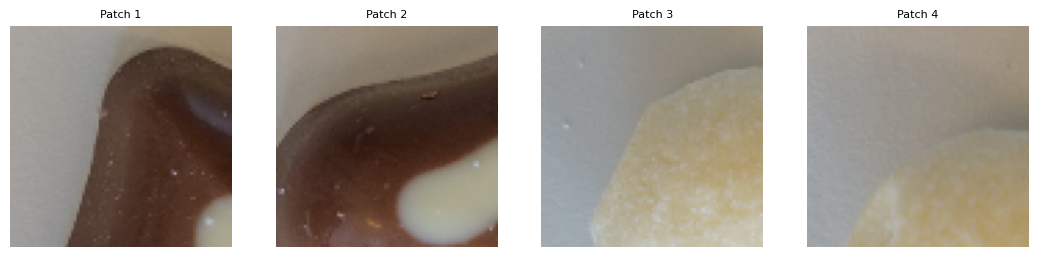

In [237]:
patches = extract_patches_from_blobs(train_image_rgb, blobs, stride=stride, window_size=window_size)

print(f"Extracted {len(patches)} patches.")

rows = int(np.ceil(len(patches) / 6))
plt.figure(figsize=(20, 4 * rows))
for i, patch in enumerate(patches):
    plt.subplot(rows, 6, i + 1)
    plt.imshow(patch)
    plt.axis('off')
    plt.title(f'Patch {i+1}', fontsize=8)


Segment and classify the patches